## Calculate sidewalk width using skeletons and centerlines

In [1]:
import os

import numpy as np
import pandas as pd

from shapely.geometry import LineString
from shapely.geometry import Point, MultiPoint, MultiLineString
from shapely.ops import linemerge, nearest_points

import geopandas as gpd
from geopandas import GeoDataFrame
from centerline.geometry import Centerline

from tqdm.notebook import tqdm_notebook
tqdm_notebook.pandas()

import upcp.utils.bgt_utils as bgt_utils
import upcp.utils.las_utils as las_utils
from sidewalk_filter import *

In [2]:
tilecode = '2386_9702'
((x_min, y_max), (x_max, y_min)) = las_utils.get_bbox_from_tile_code(tilecode, padding=1)

# Create reader for BGT sidewalk part polygons.
bgt_road_file = '../datasets/bgt/bgt_voetpad_demo.csv'
bgt_sidewalk_reader = bgt_utils.BGTPolyReader(bgt_file=bgt_road_file)

sidewalk_polygons = bgt_sidewalk_reader.filter_tile(
                            tilecode, bgt_types=['voetpad'],
                            padding=0, offset=0,
                            merge=False)

## Get Sidewalk Centerlines

In [3]:
crs = {'init': 'epsg:28992'} #local crs

/opt/anaconda3/envs/new/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


<AxesSubplot:>

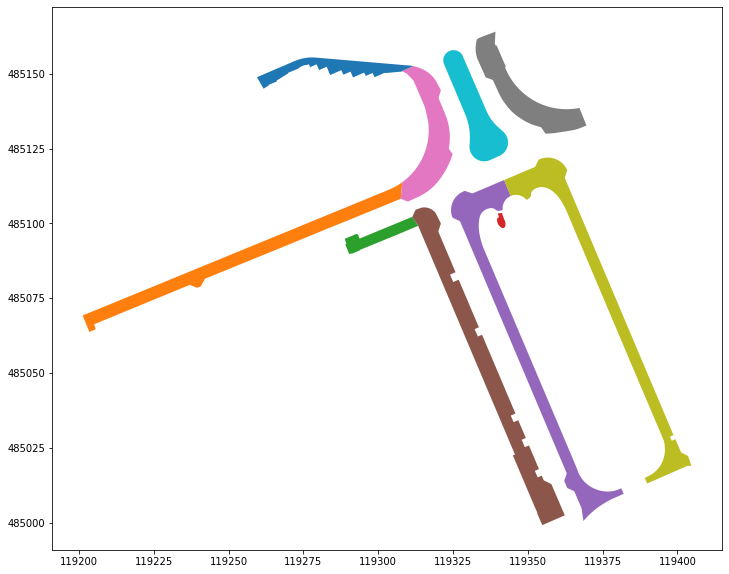

In [4]:
df = gpd.GeoDataFrame(columns=['geometry'], geometry='geometry')
df['geometry'] = sidewalk_polygons
df.crs = crs
df.plot(figsize=(12, 12), cmap='tab10')

In [5]:
df_dissolved = gpd.GeoDataFrame(geometry=gpd.GeoSeries([geom for geom in df.unary_union.geoms]))

In [6]:
df_exploded = gpd.GeoDataFrame(df_dissolved.geometry.explode())

/var/folders/rq/h813f9cd5xb5_vw7vwp2c0_40000gn/T/ipykernel_5479/3952258126.py:1: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  df_exploded = gpd.GeoDataFrame(df_dissolved.geometry.explode())


<AxesSubplot:>

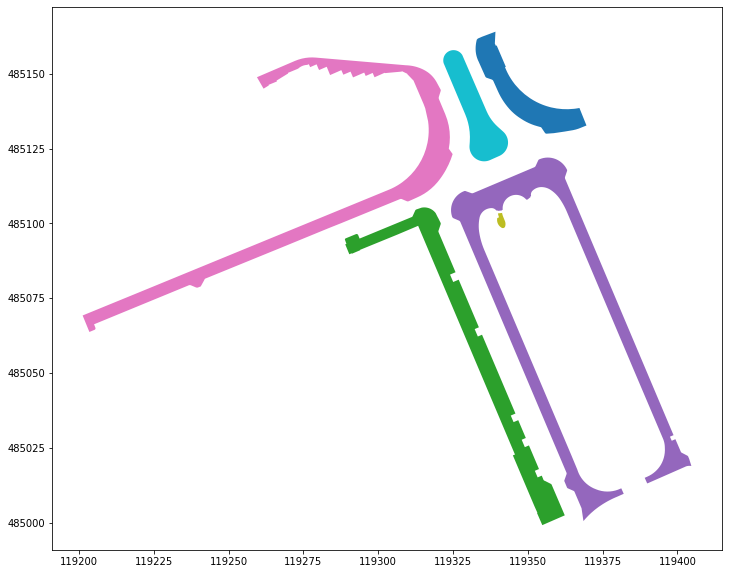

In [7]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

In [8]:
# if you get an error here, make sure you use tqdm>=4.61.2
df_exploded['centerlines'] = df_exploded.progress_apply(lambda row: Centerline(row.geometry), axis=1)

  0%|          | 0/6 [00:00<?, ?it/s]

In [9]:
df_exploded = df_exploded.set_geometry('centerlines')

<AxesSubplot:>

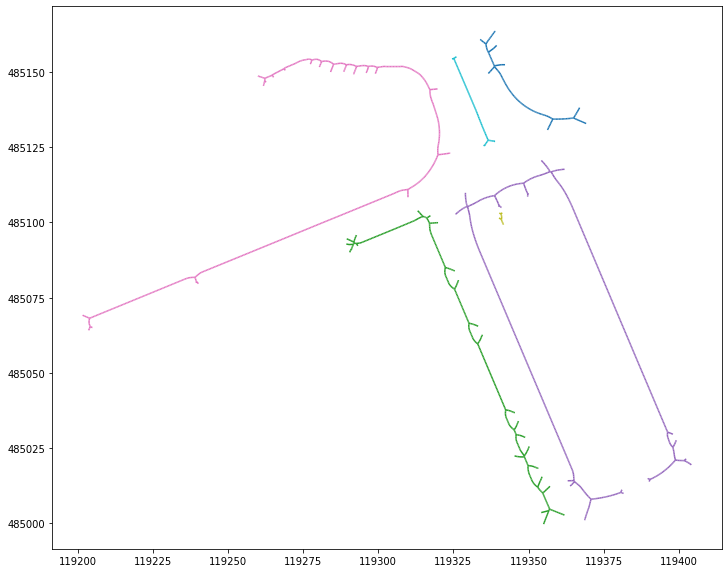

In [10]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

## Remove Short Line Ends

In [11]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(linemerge)

  0%|          | 0/6 [00:00<?, ?it/s]

In [12]:
def remove_short_lines(line):
    
    if line.type == 'MultiLineString':
        
        passing_lines = []
    
        for i, linestring in enumerate(line):
            
            other_lines = MultiLineString([x for j, x in enumerate(line) if j != i])
            
            p0 = Point(linestring.coords[0])
            p1 = Point(linestring.coords[-1])
            
            is_deadend = False
            
            if p0.disjoint(other_lines): is_deadend = True
            if p1.disjoint(other_lines): is_deadend = True
            
            if not is_deadend or linestring.length > 5:                
                passing_lines.append(linestring)
            
        return MultiLineString(passing_lines)
            
    if line.type == 'LineString':
        return line

In [13]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(remove_short_lines)

  0%|          | 0/6 [00:00<?, ?it/s]

In [14]:
df_exploded.head()

,,geometry,centerlines
0,0,"POLYGON ((119342.628 485151.589, 119342.967 48...","MULTILINESTRING ((119338.831 485163.741, 11933..."
1,0,"POLYGON ((119334.688 485062.826, 119345.855 48...","MULTILINESTRING ((119291.688 485092.700, 11929..."
2,0,"POLYGON ((119339.513 485104.270, 119339.409 48...","MULTILINESTRING ((119329.628 485105.294, 11932..."
3,0,"POLYGON ((119307.514 485108.208, 119307.462 48...","MULTILINESTRING ((119203.956 485068.109, 11920..."
4,0,"POLYGON ((119341.388 485103.522, 119341.403 48...","MULTILINESTRING ((119340.949 485101.010, 11934..."


<AxesSubplot:>

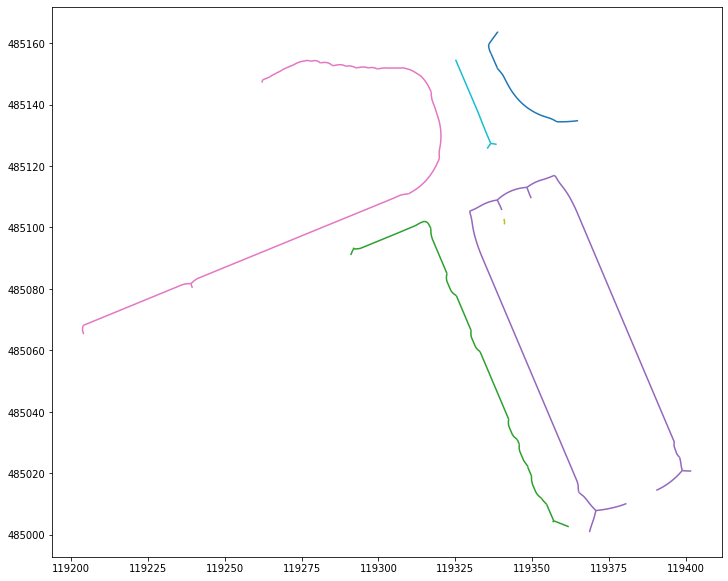

In [15]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

## Get Sidewalk Widths

In [16]:
df_exploded['centerlines'] = df_exploded['centerlines'].progress_apply(lambda row: row.simplify(1, preserve_topology=True))

  0%|          | 0/6 [00:00<?, ?it/s]

<AxesSubplot:>

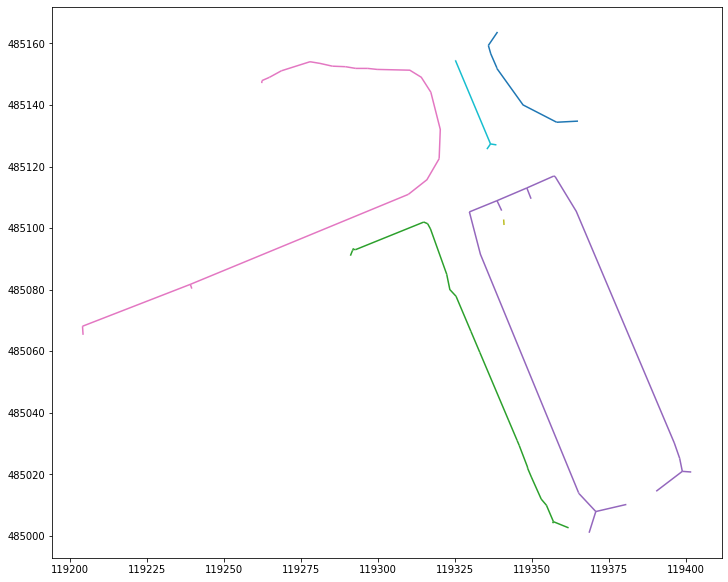

In [17]:
df_exploded.plot(figsize=(12, 12), cmap='tab10')

In [18]:
def linestring_to_segments(linestring):
    return [LineString([linestring.coords[i], linestring.coords[i+1]]) for i in range(len(linestring.coords) - 1)]

In [19]:
def get_segments(line):
    
    line_segments = []

    if line.type == 'MultiLineString':
        
        for linestring in line.geoms:
            
            line_segments.extend(linestring_to_segments(linestring))

    if line.type == 'LineString':
        
        line_segments.extend(linestring_to_segments(line))

    return line_segments

In [20]:
df_exploded.head(1)

,,geometry,centerlines
0,0,"POLYGON ((119342.628 485151.589, 119342.967 48...","MULTILINESTRING ((119338.831 485163.741, 11933..."


In [21]:
df_exploded['segments'] = df_exploded['centerlines'].progress_apply(get_segments)
df_exploded.head(1)

  0%|          | 0/6 [00:00<?, ?it/s]

,,geometry,centerlines,segments
0,0,"POLYGON ((119342.628 485151.589, 119342.967 48...","MULTILINESTRING ((119338.831 485163.741, 11933...",[LINESTRING (119338.8309943533 485163.74055367...


In [22]:
def interpolate_by_distance(linestring):
    
    distance = 1
    all_points = []
    count = round(linestring.length / distance) + 1
    
    if count == 1:
        all_points.append(linestring.interpolate(linestring.length / 2))
    
    else:
        for i in range(count):
            all_points.append(linestring.interpolate(distance * i))
    
    return all_points

def interpolate(line):
    
    if line.type == 'MultiLineString':
        
        all_points = []
        
        for linestring in line:
            all_points.extend(interpolate_by_distance(linestring))
        
        return MultiPoint(all_points)
            
    if line.type == 'LineString':
        return MultiPoint(interpolate_by_distance(line))
    
    
def polygon_to_multilinestring(polygon):

    return MultiLineString([polygon.exterior] + [line for line in polygon.interiors])
    

def get_avg_distances(row):
    
    avg_distances = []
    
    sidewalk_lines = polygon_to_multilinestring(row.geometry)
    
    for segment in row.segments:
        
        points = interpolate(segment)
        
        distances = []
        
        for point in points:
            p1, p2 = nearest_points(sidewalk_lines, point)
            distances.append(p1.distance(p2))
            
        avg_distances.append(sum(distances) / len(distances))
        
    return avg_distances

In [23]:
df_exploded['avg_distances'] = df_exploded.progress_apply(lambda row: get_avg_distances(row), axis=1)
df_exploded.head(1)

  0%|          | 0/6 [00:00<?, ?it/s]

,,geometry,centerlines,segments,avg_distances
0,0,"POLYGON ((119342.628 485151.589, 119342.967 48...","MULTILINESTRING ((119338.831 485163.741, 11933...",[LINESTRING (119338.8309943533 485163.74055367...,"[1.6056446007710106, 3.4468430431485406, 3.802..."


In [24]:
data = {'geometry': [], 'width': []}

for i, row in df_exploded.iterrows():
    
    for segment in row.segments:
        data['geometry'].append(segment)
    
    for distance in row.avg_distances:
        data['width'].append(distance * 2)
        
df_segments = pd.DataFrame(data)
df_segments = GeoDataFrame(df_segments, crs=crs, geometry='geometry')
df_segments.head(1)

/opt/anaconda3/envs/new/lib/python3.8/site-packages/pyproj/crs/crs.py:131: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


,geometry,width
0,"LINESTRING (119338.831 485163.741, 119335.855 ...",3.211289


<AxesSubplot:>

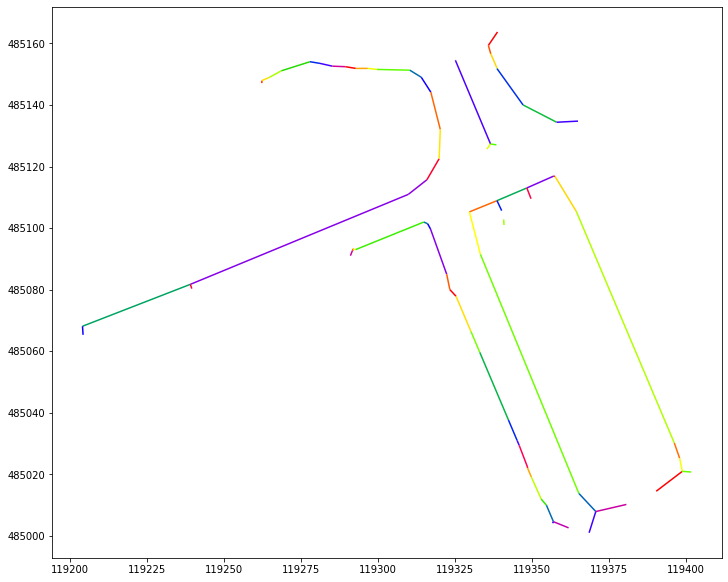

In [25]:
df_segments.plot(figsize=(12, 12), cmap='prism')

<AxesSubplot:>

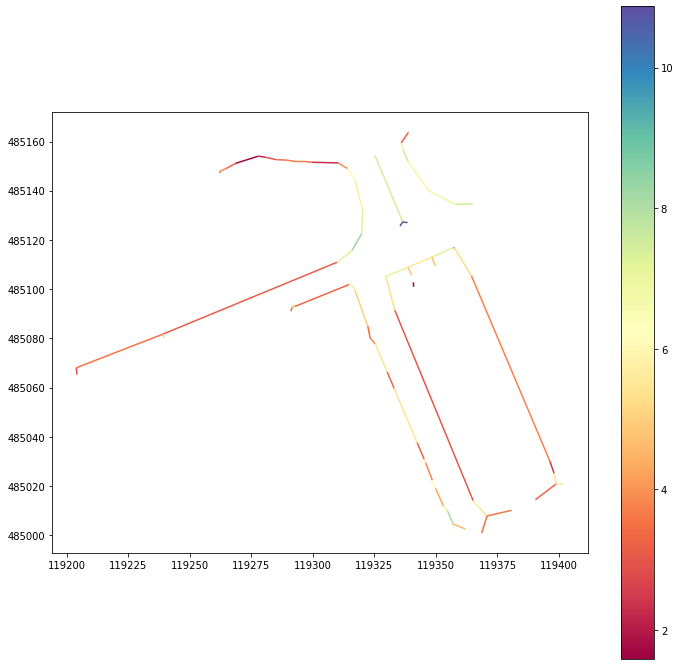

In [26]:
df_segments.plot(figsize=(12, 12), column='width', cmap='Spectral', legend=True)

In [27]:
# Moeten we de width nog converten naar juiste meters?? TODO
df_segments.head()

,geometry,width
0,"LINESTRING (119338.831 485163.741, 119335.855 ...",3.211289
1,"LINESTRING (119335.855 485159.369, 119336.643 ...",6.893686
2,"LINESTRING (119338.614 485152.100, 119336.643 ...",7.605646
3,"LINESTRING (119338.614 485152.100, 119338.676 ...",7.455203
4,"LINESTRING (119358.054 485134.404, 119347.133 ...",6.913640
